In [29]:
import tensorflow as tf
print(tf.__version__)

2.17.0


In [30]:
!pip uninstall tensorflow

Found existing installation: tensorflow 2.17.0
Uninstalling tensorflow-2.17.0:
  Would remove:
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.17.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? Y
  Successfully uninstalled tensorflow-2.17.0


In [31]:
!pip install tensorflow==2.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 79.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.7 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.0
    Uninstalling ml-dtypes-0.4.0:
      Successfully uninstalled ml-dtypes-0.4.0
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard
    Found existing installation

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, concatenate
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2



In [2]:
data=pd.read_csv('/content/drive/MyDrive/data/Twitter Analysis.csv')
data.head()

,Unnamed: 0,majority_target,statement,BinaryNumTarget,tweet,followers_count,friends_count,favourites_count,statuses_count,listed_count,...,determiners,conjunctions,dots,exclamation,questions,ampersand,capitals,digits,long_word_freq,short_word_freq
0,0,True,End of eviction moratorium means millions of A...,1.0,@POTUS Biden Blunders - 6 Month Update\n\nInfl...,4262.0,3619.0,34945.0,16423.0,44.0,...,0,0,5,0,1,0,33,3,5,19
1,1,True,End of eviction moratorium means millions of A...,1.0,@S0SickRick @Stairmaster_ @6d6f636869 Not as m...,1393.0,1621.0,31436.0,37184.0,64.0,...,0,2,1,0,0,0,14,0,2,34
2,2,True,End of eviction moratorium means millions of A...,1.0,THE SUPREME COURT is siding with super rich pr...,9.0,84.0,219.0,1184.0,0.0,...,0,1,0,0,0,0,3,0,4,10
3,3,True,End of eviction moratorium means millions of A...,1.0,@POTUS Biden Blunders\n\nBroken campaign promi...,4262.0,3619.0,34945.0,16423.0,44.0,...,0,1,3,0,0,1,6,8,1,30
4,4,True,End of eviction moratorium means millions of A...,1.0,@OhComfy I agree. The confluence of events rig...,70.0,166.0,15282.0,2194.0,0.0,...,0,1,3,0,1,0,11,3,2,19


In [3]:
# Separate data into '0' and '1' classes
data_0 = data[data['BotScoreBinary'] == 0]
data_1 = data[data['BotScoreBinary'] == 1]

In [4]:
# Randomly select 20,000 rows from '0' class if available
if len(data_0) > 20000:
    data_0 = data_0.sample(n=20000, random_state=42)

In [5]:
# Combine reduced '0' class with '1' class
data = pd.concat([data_0, data_1], ignore_index=True)

In [6]:
# Separate features and target
x = data.drop(columns=['BotScoreBinary'])
y = data['BotScoreBinary']

In [7]:
y.value_counts()


,count
BotScoreBinary,
0.0,20000
1.0,4342


In [8]:
# Text data (tweet) preprocessing
max_words = 1000  # Max number of words in tokenizer
max_sequence_length = 100  # Max length of each sequence (tweets)

In [9]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x['tweet'])
sequences = tokenizer.texts_to_sequences(x['tweet'])
x_text = pad_sequences(sequences, maxlen=max_sequence_length)

In [10]:
# Numeric features scaling
numeric_features = [
    'retweets',
    'mentions',
    'adjectives',
    'adverbs',
    'pronouns',
    'capitals',
    'digits',
    'hashtags',
    'URLs',
    'ORG_percentage',
    'PERSON_percentage'
]

In [11]:
x_numeric = data[numeric_features].values
scaler = StandardScaler()
x_numeric_scaled = scaler.fit_transform(x_numeric)

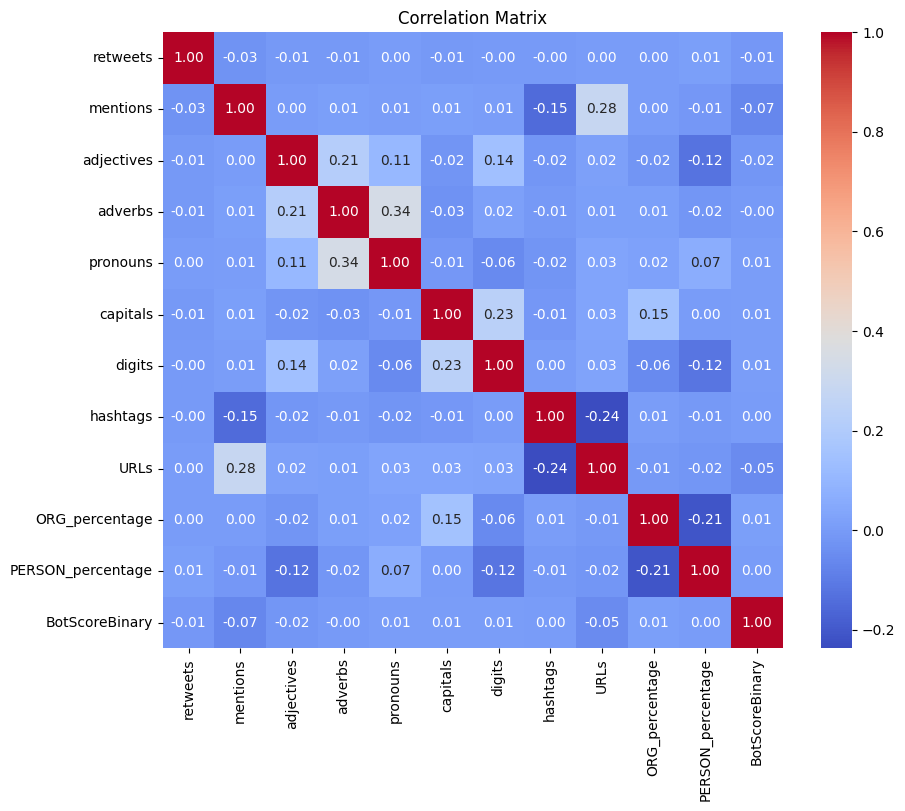

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assume x_numeric is the DataFrame of your numeric features and y is the target variable
x_numeric = pd.DataFrame(x_numeric_scaled, columns=numeric_features)

# Combine features with the target variable
data_combined = pd.concat([x_numeric, y], axis=1)

# Correlation matrix
correlation_matrix = data_combined.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


In [13]:
# Split data into training and testing sets
x_train_text, x_test_text, x_train_numeric, x_test_numeric, y_train, y_test = train_test_split(
    x_text, x_numeric_scaled, y, test_size=0.2, random_state=42)

In [14]:
# Address class imbalance
smote = SMOTE(random_state=42)
x_train_text_resampled, y_train_resampled = smote.fit_resample(x_train_text, y_train)
x_train_numeric_resampled, y_train_resampled = smote.fit_resample(x_train_numeric, y_train)

In [15]:
# Define RNN model architecture
embedding_dim = 50  # Dimension of word embeddings

In [16]:
# Text input branch
text_input = Input(shape=(max_sequence_length,), name='text_input')
embedding_layer = Embedding(input_dim=max_words, output_dim=embedding_dim)(text_input)
lstm_layer = LSTM(30, kernel_regularizer=l2(0.01))(embedding_layer)
dropout_text = Dropout(0.5)(lstm_layer)

In [17]:
# Numeric input branch
numeric_input = Input(shape=(len(numeric_features),), name='numeric_input')
dense_layer = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(numeric_input)
dropout_numeric = Dropout(0.5)(dense_layer)

In [18]:
# Concatenate both branches
concatenated = concatenate([dropout_text, dropout_numeric])

In [19]:
# Output layer
output = Dense(1, activation='sigmoid', name='output')(concatenated)

In [20]:
from tensorflow.keras.optimizers import AdamW


In [21]:
# Define optimizer with a specific learning rate
optimizer  = AdamW(learning_rate=0.001)


In [22]:
# Create model
model = Model(inputs=[text_input, numeric_input], outputs=output)

In [23]:
# Compile model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_input (InputLayer)     [(None, 100)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 100, 50)              50000     ['text_input[0][0]']          
                                                                                                  
 numeric_input (InputLayer)  [(None, 11)]                 0         []                            
                                                                                                  
 lstm (LSTM)                 (None, 30)                   9720      ['embedding[0][0]']           
                                                                                              

In [24]:

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [25]:
# Train model
history = model.fit(
    {'text_input': x_train_text_resampled, 'numeric_input': x_train_numeric_resampled},
    y_train_resampled,
    epochs=100,
    batch_size=64,
    validation_data=({'text_input': x_test_text, 'numeric_input': x_test_numeric}, y_test),
    callbacks=[early_stopping]
)

Epoch 1/100
500/500 [==============================] - 28s 41ms/step - loss: 0.7709 - accuracy: 0.6394 - val_loss: 0.6999 - val_accuracy: 0.6108
Epoch 2/100
500/500 [==============================] - 7s 13ms/step - loss: 0.5839 - accuracy: 0.7073 - val_loss: 0.5780 - val_accuracy: 0.7490
Epoch 3/100
500/500 [==============================] - 6s 11ms/step - loss: 0.5603 - accuracy: 0.7244 - val_loss: 0.5912 - val_accuracy: 0.7164
Epoch 4/100
500/500 [==============================] - 5s 9ms/step - loss: 0.5476 - accuracy: 0.7338 - val_loss: 0.6054 - val_accuracy: 0.7209
Epoch 5/100
500/500 [==============================] - 6s 12ms/step - loss: 0.5386 - accuracy: 0.7391 - val_loss: 0.6289 - val_accuracy: 0.6880


In [26]:
# Evaluate model on train set
train_loss, train_accuracy = model.evaluate({'text_input': x_train_text_resampled, 'numeric_input': x_train_numeric_resampled}, y_train_resampled)
print(f'Train accuracy: {train_accuracy}')

999/999 [==============================] - 4s 4ms/step - loss: 0.5707 - accuracy: 0.7247
Train accuracy: 0.7246776223182678


In [27]:

# Evaluate model on test set
test_loss, test_accuracy = model.evaluate({'text_input': x_test_text, 'numeric_input': x_test_numeric}, y_test)
print(f'Test accuracy: {test_accuracy}')

153/153 [==============================] - 1s 4ms/step - loss: 0.5780 - accuracy: 0.7490
Test accuracy: 0.7490244507789612


In [28]:
import matplotlib.pyplot as plt


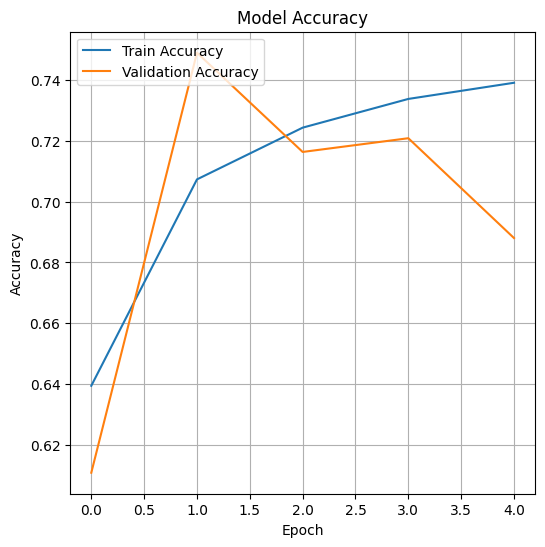

In [29]:
# Plot training & validation accuracy values
plt.figure(figsize=(6, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [30]:
# Predict on test set
y_pred = model.predict({'text_input': x_test_text, 'numeric_input': x_test_numeric})
y_pred_classes = (y_pred > 0.5).astype(int)

153/153 [==============================] - 1s 3ms/step


In [31]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
print(cm)

[[3443  583]
 [ 639  204]]


In [32]:
import seaborn as sns


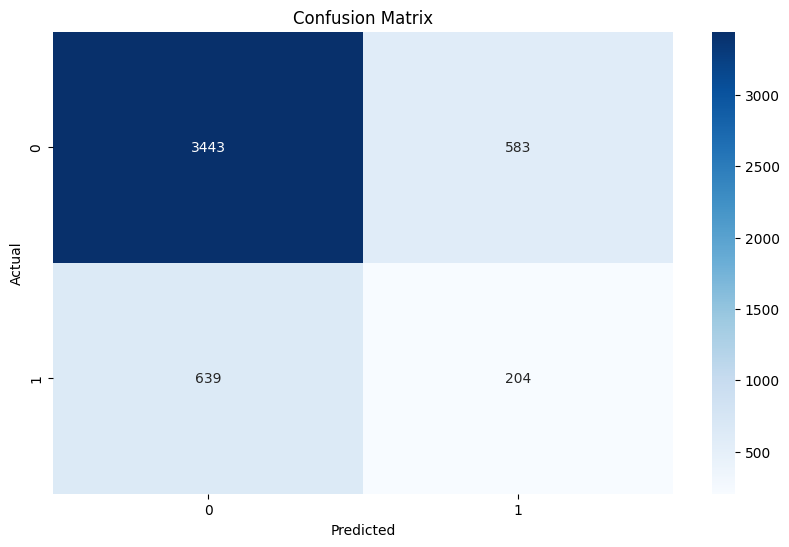

In [33]:
# Plot confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

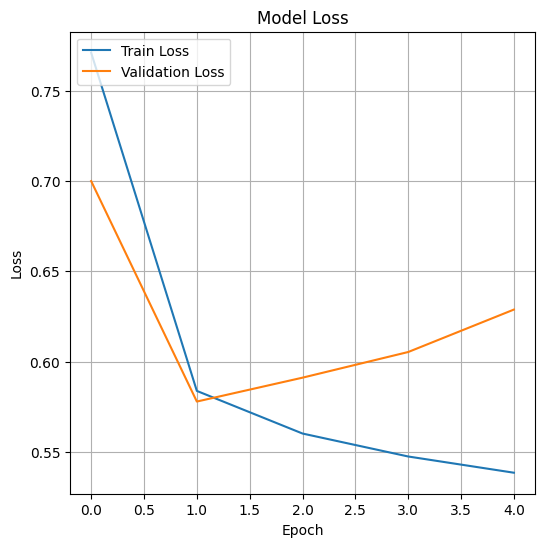

In [34]:
# Plot training & validation loss values
plt.figure(figsize=(6, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [35]:
#model.save('twitter_bot_detection_model.h5')


preprocessing srilankan data for retraining

In [36]:
#data1 = pd.read_csv('/content/drive/MyDrive/Dataset/updated_tweets.csv')
#data1.head()

In [37]:
#column_names = data1.columns
#print(column_names)